In [22]:
from pyscf import gto, scf, mp, cc, dft
import numpy as np
import ase

from matplotlib import pyplot as plt

import pandas as pd
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import utils_qm as uqm
#import warnings
#warnings.filterwarnings("ignore")
#warnings.filterwarnings( "ignore", module = "/home/misa/anaconda3/envs/atomic-energies/lib/python3.7/site-packages/matplotlib/*" )

In [4]:
amons_db = pd.read_pickle('/home/misa/datasets/amons_qm9_11k/amons_database.pd')

In [7]:
amons_dict = uqm.load_obj('/home/misa/datasets/amons_qm9_11k/unique_amons_dict')

In [24]:
ethane_text = amons_dict['CC']

In [25]:
coords = []
elements = ''
for line in ethane_text[2:]:
    el, x, y, z = line.split()
    coords.append([float(x),float(y),float(z)])
    elements += el

In [33]:
ethane = ase.Atoms(elements, coords)
coords = ethane.get_positions()
vec_CC = coords[1] - coords[0]
d_CC = np.linalg.norm(vec_CC)

In [73]:
stretch_percentage = np.array([0.85, 1.0, 1.2, 1.5, 2])
shift_vecs = []
for sp in stretch_percentage:
    shift_vec = vec_CC*sp - vec_CC
    #print(np.linalg.norm(vec_CC*sp)/d_CC)
    shift_vecs.append(shift_vec)

In [74]:

e_pbe = []

for sv in shift_vecs:
    new_coords = ethane.get_positions().copy()
    new_coords[1] += sv
    new_coords[5] += sv
    new_coords[6] += sv
    new_coords[7] += sv
    
    atom = []
    for a, c in zip(elements, new_coords):
        atom.append([a, (c)])
    
    
    new_coords = ethane.get_positions().copy()
    new_coords[1] += sv
    new_coords[5] += sv
    new_coords[6] += sv
    new_coords[7] += sv

    atom = []
    for a, c in zip(elements, new_coords):
        atom.append([a, c])

    mol = gto.Mole()
    mol.verbose = 0
    #mol.output = 'H2_{}.log'.format(d)
    mol.atom = atom
    mol.basis = 'def2tzvp'
    mol.build()

    # PBE
    mdft = dft.RKS(mol)
    mdft.xc = 'pbe'
    e_pbe.append(mdft.kernel())
    
    

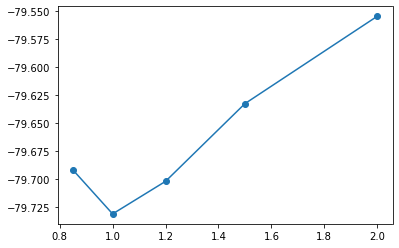

In [75]:
plt.plot(stretch_percentage, e_pbe, '-o')